Comparisons of locomotion predictions of different mechanistic latent variable models.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_plot


STRAIN_KEY = '_'.join(['NM91', 'ZH23']).lower()
REG_KEY = 'ridge_alpha_10'

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

MASKED = True

# Basic comparison of single vs population fits using different neural models.

In [2]:
NNRN = 224
NRL_MDLS = [
    'ma',  # mult-adapt neural model
    
    'lnma',  # lin-nonlin neural model w MA-derived filters
    'lnr',  # linear-nonlinear model (fit w ridge regr)
#     'lnr_relu',  
    'lnr_relu_flex',
    'lnma_tweaked',  # lin-nonlin neural model w double-exp filter optimized from MA fit
    
    'linma',  # linear neural model w MA-derived filters
    
#     'linr',  # linear neural model (fit w ridge regr)
    
    'ma_ind_ta',
    
#     'lin',  # linear neural model
#     'ln',  # linear-nonlinear model
]

LABELS = {
    'ma': 'MA',
    'lnma': 'LNMA',
    'lnr': 'LN-R',
    'lnr_relu_flex': 'LN_FLEX',
    'lnma_tweaked': 'LNMA_TW',
    
    'linma': 'Lin',
    
    'ma_ind_ta': 'MA_IND_TA',
    
    'MTN': 'Motion',
}

In [3]:
if not MASKED:
    # heuristic predictors
    time_rslt = np.load(f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]

    # linear fits
    lin_rslt = np.load(f'data/simple/mlv/lin_filter/rc_lin_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]

    # single-neuorn fits
    single_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # ppln fits
    ppln_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # shuffled MA fit
    shfl_rslt = np.load(f'data/simple/mlv/ma_shfl/baker_ma_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]
    
else:
    # heuristic predictors
    time_rslt = np.load(f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{TARG_BHV.lower()}_masked.npy', allow_pickle=True)[0]

    # linear fits
    lin_rslt = np.load(f'data/simple/mlv/lin_filter/rc_lin_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]

    # single-neuorn fits
    single_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}_masked.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # ppln fits
    ppln_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # shuffled MA fit
    shfl_rslt = np.load(f'data/simple/mlv/ma_shfl/baker_ma_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]

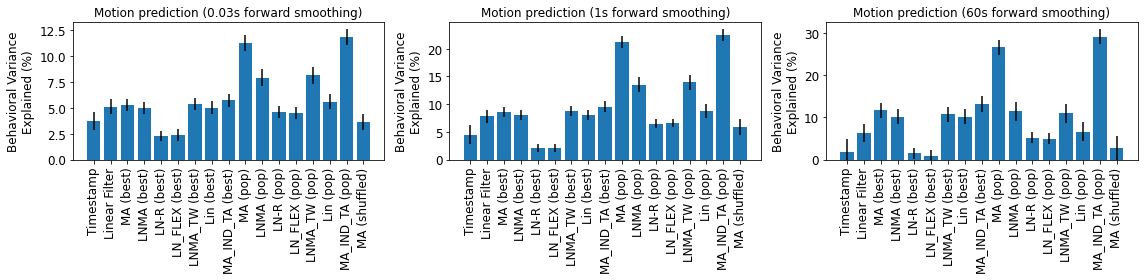

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4), tight_layout=True)
                
for ax, twdw in zip(axs, TWDWS):
    labels = []
    r2_mns = []
    r2_sems = []
    
    targ = f'{TARG_BHV}_MN_{twdw}'
    
    # heuristics
    labels.append('Timestamp')
    r2_mns.append(time_rslt['r2_test'][targ].mean())
    r2_sems.append(time_rslt['r2_test'][targ].std() / np.sqrt(time_rslt['nsplit']))
    
    # linear fits
    labels.append('Linear Filter')
    r2_mns.append(lin_rslt['r2_test'][targ].mean())
    r2_sems.append(lin_rslt['r2_test'][targ].std() / np.sqrt(lin_rslt['nsplit']))
    
    # single neuron results
    for nrl_mdl, single_rslt in zip(NRL_MDLS, single_rslts):
        r2_maxs = single_rslt['r2_test'][targ].max(axis=1)
        labels.append(f'{LABELS[nrl_mdl]} (best)')
        r2_mns.append(r2_maxs.mean())
        r2_sems.append(r2_maxs.std() / np.sqrt(len(r2_maxs)))
        
    # ppln results
    for nrl_mdl, ppln_rslt in zip(NRL_MDLS, ppln_rslts):
        labels.append(f'{LABELS[nrl_mdl]} (pop)')
        r2_mns.append(ppln_rslt['r2_test'][targ].mean())
        r2_sems.append(ppln_rslt['r2_test'][targ].std() / np.sqrt(ppln_rslt['nsplit']))
        
    # shuffled MA fit
    labels.append('MA (shuffled)')
    r2_mns.append(shfl_rslt['r2_test'][targ].mean())
    r2_sems.append(shfl_rslt['r2_test'][targ].std() / np.sqrt(shfl_rslt['nshfl']))
        
    r2_mns = np.array(r2_mns)
    r2_sems = np.array(r2_sems)
    
    ax.bar(np.arange(len(r2_mns)), 100*r2_mns, yerr=100*r2_sems)
    ax.set_ylim(bottom=0)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    set_plot(ax, y_label='Behavioral Variance\nExplained (%)', title=f'{LABELS[TARG_BHV]} prediction ({twdw}s forward smoothing)', font_size=12)

# Behavioral predictions from perturbed surrogate population recordings

In [6]:
KBHVS_FOLDERS_KEYS = [
    ('ma', 'neur_basic', 'Full MA pop.'),
    (None, None, None),
    ('ma_no_sel', 'ma_pert', 'No selectivity'),
    ('ma_pure_sel', 'ma_pert', 'Pure selectivity'),
    ('ma_sine_sel', 'ma_pert', 'Sine selective'),
    ('ma_pulse_sel', 'ma_pert', 'Pulse selective'),
    (None, None, None),
#     ('ma_stim_inv_adapt', 'ma_alt', 'Stim-inv adapt'),
    ('ma_no_adapt', 'ma_pert', 'No adaptation'),
    (None, None, None),
    ('ma_fast_r_fast_a', 'ma_pert', r'Fast $\tau_r$, fast $\tau_a$'),
    ('ma_fast_r_med_a', 'ma_pert', r'Fast $\tau_r$, med $\tau_a$'),
    ('ma_fast_r_slow_a', 'ma_pert', r'Fast $\tau_r$, slow $\tau_a$'),
    (None, None, None),
    ('ma_med_r_fast_a', 'ma_pert', r'Med. $\tau_r$, fast $\tau_a$'),
    ('ma_med_r_med_a', 'ma_pert', r'Med. $\tau_r$, med $\tau_a$'),
    ('ma_med_r_slow_a', 'ma_pert', r'Med. $\tau_r$, slow $\tau_a$'),
    (None, None, None),
    ('ma_slow_r_fast_a', 'ma_pert', r'Slow $\tau_r$, fast $\tau_a$'),
    ('ma_slow_r_med_a', 'ma_pert', r'Slow $\tau_r$, med $\tau_a$'),
    ('ma_slow_r_slow_a', 'ma_pert', r'Slow $\tau_r$, slow $\tau_a$'),
]

rslts_1 = []
rslts_60 = []

for kbhv, folder, key in KBHVS_FOLDERS_KEYS:
    if folder is not None:
        if not MASKED:
            fit_data = np.load(f'data/simple/mlv/{folder}/baker_{kbhv}_nm91_zh23_mtn_ridge_alpha_10.npy', allow_pickle=True)[0]
        else:
            fit_data = np.load(f'data/simple/mlv/{folder}/baker_{kbhv}_nm91_zh23_mtn_ridge_alpha_10_masked.npy', allow_pickle=True)[0]

        nsplit = len(fit_data['r2_test']['MTN_MN_60'])

        r2_1 = fit_data['r2_test']['MTN_MN_1'].mean()
        err_1 = fit_data['r2_test']['MTN_MN_1'].std()/np.sqrt(nsplit)
        
        r2_60 = fit_data['r2_test']['MTN_MN_60'].mean()
        err_60 = fit_data['r2_test']['MTN_MN_60'].std()/np.sqrt(nsplit)
    else:
        r2_1 = np.nan
        err_1 = np.nan
        r2_60 = np.nan
        err_60 = np.nan
    
    rslts_1.append((key, r2_1, err_1))
    rslts_60.append((key, r2_60, err_60))

/Users/rp21/opt/miniconda3/envs/sci/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


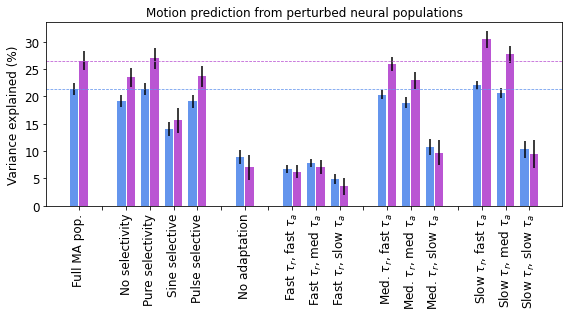

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5), tight_layout=True, sharey=True)
colors = ['cornflowerblue', 'mediumorchid']
for crslts, (color, rslts) in enumerate(zip(colors, [rslts_1, rslts_60])):
    x_offset = -.2 + crslts*.4
    for crslt, (key, r2, err) in enumerate(rslts):
        ax.bar([crslt+x_offset], [r2*100], yerr=[err*100], width=.35, color=color)

    ax.axhline(100*rslts[0][1], ls='--', lw=.75, color=color)
    ax.set_xticks(np.arange(len(rslts)))
    ax.set_xticklabels([rslt[0] for rslt in rslts], rotation=90)

    set_plot(ax, y_label='Variance explained (%)', title='Motion prediction from perturbed neural populations', font_size=12)
    
# fig.savefig('ms/fig2j.svg')

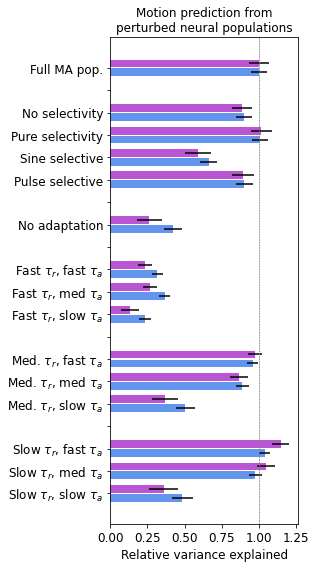

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 8), tight_layout=True, sharey=True)
colors = ['cornflowerblue', 'mediumorchid']
for crslts, (color, rslts) in enumerate(zip(colors, [rslts_1, rslts_60])):
    max_r2 = rslts[0][1]
    y_offset = -.2 + crslts*.4
    for crslt, (key, r2, err) in enumerate(rslts):
        ax.barh([-crslt+y_offset], [r2/max_r2], xerr=[err/max_r2], height=.35, color=color)
        
    ax.axvline(1, color='gray', ls='--', lw=.5)

    ax.set_yticks(-np.arange(len(rslts)))
    ax.set_yticklabels([rslt[0] for rslt in rslts])

    set_plot(ax, x_label='Relative variance explained', title='Motion prediction from\nperturbed neural populations', font_size=12)

## MTN prediction from heuristics

In [9]:
SONG_HEURS = ['N_S_ONSETS', 'N_P_ONSETS', 'N_B_ONSETS', 'S_TOTAL', 'P_TOTAL', 'B_TOTAL']
LABELS = {
    'N_S_ONSETS': '# Sine onsets',
    'N_P_ONSETS': '# Pulse onsets',
    'N_B_ONSETS': '# Song onsets',
    'S_TOTAL': 'Total sine song',
    'P_TOTAL': 'Total pulse song',
    'B_TOTAL': 'Total song',
}
WDWS_HEUR = [1, 10, 30, 60, 120, 1800]
# WDWS_HEUR = [1, 10, 30, 60, 120]

if not MASKED:
    FSAVE = f'data/simple/mlv/heuristic/heuristics_single_{STRAIN_KEY}_{TARG_BHV.lower()}.npy'
else:
    FSAVE = f'data/simple/mlv/heuristic/heuristics_single_{STRAIN_KEY}_{TARG_BHV.lower()}_masked.npy'
    

data = np.load(FSAVE, allow_pickle=True)[0]

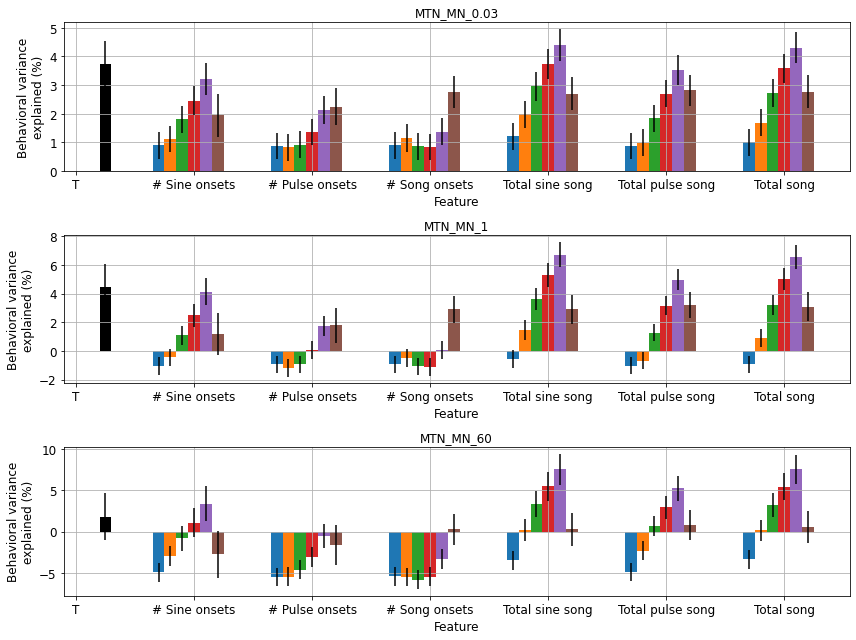

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9), tight_layout=True)
w_bar = 0.1

for ax, targ in zip(axs, TARGS):
    r2_test_mn = data['r2_test'][targ].mean(0)
    r2_test_sem = data['r2_test'][targ].std(0)/np.sqrt(len(data['heurs']))
    
    r2_test_mn_dict = {heur: r2_test_mn_ for heur, r2_test_mn_ in zip(data['heurs'], r2_test_mn)}
    r2_test_sem_dict = {heur: r2_test_sem_ for heur, r2_test_sem_ in zip(data['heurs'], r2_test_sem)}
    
    x_off = -.75
    x = np.array([x_off])
    y = np.array([r2_test_mn_dict['T']])
    y_err = np.array([r2_test_sem_dict['T']])
    
    ax.bar(x, 100*y, yerr=100*y_err, width=w_bar, color='k')
    
    for cwdw, wdw in enumerate(WDWS_HEUR):
        x_off = w_bar*cwdw - 0.3
        x = np.arange(len(SONG_HEURS)) + x_off
        y = np.array([r2_test_mn_dict[f'{heur}_{wdw}'] for heur in SONG_HEURS])
        y_err = np.array([r2_test_sem_dict[f'{heur}_{wdw}'] for heur in SONG_HEURS])
        ax.bar(x, 100*y, yerr=100*y_err, width=w_bar)
        
    ax.set_xticks(-1+np.arange(len(SONG_HEURS)+1))
    ax.set_xticklabels(['T'] + [LABELS[song_heur] for song_heur in SONG_HEURS])
    ax.set_xlabel('Feature')
    
    set_plot(ax, y_label='Behavioral variance\nexplained (%)', title=targ, font_size=12)
    ax.grid()